In [6]:
print("Notebook for the 3 agents evaluation.")

Notebook for the 3 agents evaluation.


In [7]:
# ============================================================================
# CELL 0 : SETUP - PHASE 3D (FINAL EVALUATION)
# ============================================================================

import os
import sys
from pathlib import Path

os.chdir('/workspaces/energy-rl-project')
sys.path.insert(0, '/workspaces/energy-rl-project/src')

os.environ['EPLUS_PATH'] = '/usr/local/EnergyPlus-24-2-0'

# ⭐ IMPORTS STANDARDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
import torch
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import shutil

# ⭐ IMPORTS PROJET
from src.config import DATA_OFFLINE_DIR, RESULTS_LOGS_DIR, RESULTS_FIGURES_DIR
from src.environments import BuildingBatteryEnv
from src.algorithms.cql import CQL  # Offline RL
from src.algorithms.sac import SAC, ReplayBuffer as SACReplayBuffer  # Online RL
from src.algorithms.td3 import TD3, ReplayBuffer as TD3ReplayBuffer  # Online RL
from src.algorithms.offline_replay_buffer import load_statistics

print("=" * 80)
print("🎯 PHASE 3D : FINAL EVALUATION & COMPARISON")
print("=" * 80)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n📊 Device: {device}")

# ⭐ VÉRIFIER QUE LES CHECKPOINTS EXISTENT
checkpoints_dir = RESULTS_FIGURES_DIR.parent / 'checkpoints'
checkpoints_required = {
    'CQL': checkpoints_dir / 'cql_agent.pt',
    'SAC': checkpoints_dir / 'sac_agent.pt',
    'TD3': checkpoints_dir / 'td3_agent.pt',
}

print(f"\n🔍 Checking checkpoints...")
for agent_name, path in checkpoints_required.items():
    if path.exists():
        print(f"   ✅ {agent_name}: {path}")
    else:
        print(f"   ❌ {agent_name}: NOT FOUND - {path}")
        print(f"      Run Phase 3A, 3B, 3C first!")
        sys.exit(1)

# ⭐ CHARGER LES STATS DE NORMALISATION (pour CQL)
print(f"\n📈 Loading normalization statistics...")
try:
    norm_stats = load_statistics(str(DATA_OFFLINE_DIR / 'normalization_stats.json'))
    print(f"   ✅ Normalization stats loaded")
    print(f"      - Obs mean: {norm_stats['obs_mean'][:3]}...")
    print(f"      - Obs std: {norm_stats['obs_std'][:3]}...")
except Exception as e:
    print(f"   ❌ Error loading normalization stats: {e}")
    sys.exit(1)

# ⭐ CRÉER UN ENV TEMPORAIRE POUR OBTENIR LES DIMENSIONS
print(f"\n🔧 Getting state/action dimensions...")
try:
    base_env = gym.make('Eplus-5zone-hot-continuous-v1')
    wrapped_env = BuildingBatteryEnv(
        env=base_env,
        battery_capacity=10.0,
        battery_efficiency=0.9,
        battery_power_max=5.0,
        soc_min=0.2,
        soc_max=0.9,
        pv_max_power=5.0,
        pv_efficiency=0.2,
        price_on_peak=0.25,
        price_off_peak=0.10,
        comfort_temp_range=(21.0, 25.0),
        lambda_comfort=1.0,
        lambda_battery=0.1
    )
    obs, _ = wrapped_env.reset()
    state_dim = obs.shape[0]
    action_dim = wrapped_env.action_space.shape[0]
    wrapped_env.close()
    base_env.close()
    
    print(f"   ✅ State dim: {state_dim}")
    print(f"   ✅ Action dim: {action_dim}")
except Exception as e:
    print(f"   ❌ Error: {e}")
    sys.exit(1)

# ⭐ CHARGER LES TROIS AGENTS
print(f"\n📥 Loading trained agents...")

# CQL
try:
    cql_agent = CQL(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=256,
        learning_rate=3e-4,
        gamma=0.99,
        cql_weight=10.0,
        cql_temp=0.3,
        num_random_actions=10,
        device=device
    )
    cql_agent.load(str(checkpoints_required['CQL']))
    print(f"   ✅ CQL agent loaded")
except Exception as e:
    print(f"   ❌ CQL loading error: {e}")
    sys.exit(1)

# SAC
try:
    sac_agent = SAC(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=256,
        learning_rate=3e-4,
        gamma=0.99,
        tau=0.005,
        alpha=0.5,
        device=device
    )
    sac_agent.load(str(checkpoints_required['SAC']))
    print(f"   ✅ SAC agent loaded")
except Exception as e:
    print(f"   ❌ SAC loading error: {e}")
    sys.exit(1)

# TD3
try:
    td3_agent = TD3(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=256,
        learning_rate=3e-4,
        gamma=0.99,
        tau=0.005,
        policy_delay=2,
        noise_std=0.4,
        device=device,
        action_low=np.array([12., 23.25, -1.]),
        action_high=np.array([23.25, 30., 1.])
    )
    td3_agent.load(str(checkpoints_required['TD3']))
    print(f"   ✅ TD3 agent loaded")
except Exception as e:
    print(f"   ❌ TD3 loading error: {e}")
    sys.exit(1)

print("\n" + "=" * 80)
print("✅ SETUP TERMINÉ - Tous les agents chargés")
print("=" * 80)

🎯 PHASE 3D : FINAL EVALUATION & COMPARISON

📊 Device: cpu

🔍 Checking checkpoints...
   ✅ CQL: /workspaces/energy-rl-project/results/checkpoints/cql_agent.pt
   ✅ SAC: /workspaces/energy-rl-project/results/checkpoints/sac_agent.pt
   ✅ TD3: /workspaces/energy-rl-project/results/checkpoints/td3_agent.pt

📈 Loading normalization statistics...
✅ Statistics loaded from /workspaces/energy-rl-project/data/offline_dataset/normalization_stats.json
   ✅ Normalization stats loaded
      - Obs mean: [1.0, 1.848, 10.4]...
      - Obs std: [1.0, 0.7699974025929394, 6.699253689778056]...

🔧 Getting state/action dimensions...
#==============================================================================================#  
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                                 
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1                             
#==============================================================================================#   
[MODEL

In [8]:
# ============================================================================
# CELL 1 : FONCTION EVALUATE_AGENT() - RÉUTILISABLE
# ============================================================================

def evaluate_agent(
    agent_name,
    agent,
    num_episodes=10,
    buildings_list=None,
    max_steps=250,
    deterministic=True,
    norm_stats=None
):
    """
    Évaluer un agent sur plusieurs épisodes.
    
    Args:
        agent_name: 'CQL', 'SAC', ou 'TD3'
        agent: Instance d'agent entraîné
        num_episodes: Nombre d'épisodes d'évaluation (défaut: 10)
        buildings_list: Liste de bâtiments à utiliser (défaut: tous)
        max_steps: Étapes max par épisode (défaut: 250)
        deterministic: Utiliser policy déterministe (défaut: True pour éval)
        norm_stats: Stats de normalisation (pour CQL uniquement)
    
    Returns:
        Dict avec résultats d'évaluation
    """
    
    if buildings_list is None:
        buildings_list = [
            'Eplus-5zone-hot-continuous-v1',
            'Eplus-5zone-cool-continuous-v1',
            'Eplus-5zone-mixed-continuous-v1',
        ]
    
    # ⭐ DICTIONNAIRE POUR STOCKER LES RÉSULTATS
    results = {
        'agent': agent_name,
        'episodes': [],
        'rewards': [],
        'lengths': [],
        'costs': [],
        'soc_trajectories': [],
        'comfort_violations': [],
        'battery_health': [],
        'energy_efficiency': [],
    }
    
    print(f"\n{'=' * 80}")
    print(f"📊 EVALUATING {agent_name.upper()} ({num_episodes} episodes)")
    print(f"{'=' * 80}")
    print(f"Buildings: {[b.split('-')[1] for b in buildings_list]}")
    print(f"Deterministic: {deterministic}")
    
    # ⭐ LIGNE CORRIGÉE : gestion CQL sans .actor
    if hasattr(agent, 'actor'):
        print(f"Device: {'GPU' if next(agent.actor.parameters()).is_cuda else 'CPU'}")
    else:
        # Pour CQL (qui utilise q_network_1)
        print(f"Device: {'GPU' if next(agent.q_network_1.parameters()).is_cuda else 'CPU'} (CQL)")
    print()
    
    # ⭐ BOUCLE D'ÉVALUATION
    for ep_num in range(num_episodes):
        building_id = buildings_list[ep_num % len(buildings_list)]
        
        try:
            # Créer env
            base_env = gym.make(building_id)
            wrapped_env = BuildingBatteryEnv(
                env=base_env,
                battery_capacity=10.0,
                battery_efficiency=0.9,
                battery_power_max=5.0,
                soc_min=0.2,
                soc_max=0.9,
                pv_max_power=5.0,
                pv_efficiency=0.2,
                price_on_peak=0.25,
                price_off_peak=0.10,
                comfort_temp_range=(21.0, 25.0),
                lambda_comfort=1.0,
                lambda_battery=0.1
            )
        except Exception as e:
            print(f"Episode {ep_num + 1}: ❌ Env error: {e}")
            continue
        
        # Reset
        try:
            obs, info = wrapped_env.reset()
        except Exception as e:
            print(f"Episode {ep_num + 1}: ❌ Reset error: {e}")
            wrapped_env.close()
            base_env.close()
            continue
        
        # ⭐ EPISODE LOOP
        total_reward = 0
        episode_length = 0
        total_cost = 0
        soc_traj = []
        temp_traj = []
        comfort_violations = 0
        
        for step in range(max_steps):
            try:
                # ⭐ NORMALISER OBS POUR CQL
                if agent_name == 'CQL' and norm_stats:
                    obs_normalized = (np.array(obs) - np.array(norm_stats['obs_mean'])) / np.array(norm_stats['obs_std'])
                    action = agent.select_action(obs_normalized, deterministic=deterministic)
                else:
                    # SAC et TD3 utilisent obs brute
                    action = agent.select_action(obs, deterministic=deterministic)
                
                # ⭐ VÉRIFIER ACTION BOUNDS
                if not wrapped_env.action_space.contains(action):
                    action = wrapped_env.action_space.sample()
                
                # Step
                next_obs, reward, terminated, truncated, info = wrapped_env.step(action)
                done = terminated or truncated
                
                # Collecter metrics
                total_reward += reward
                total_cost += info.get('electricity_cost', 0.0)
                soc_traj.append(info.get('soc', 0.5))
                temp_traj.append(obs[1] if len(obs) > 1 else 22.0)  # obs[1] = zone temp
                
                # Vérifier confort (27°C = trop chaud, 21°C = trop froid)
                current_temp = obs[1] if len(obs) > 1 else 22.0
                if current_temp < 21.0 or current_temp > 27.0:
                    comfort_violations += 1
                
                obs = next_obs
                episode_length += 1
                
                if done:
                    break
            
            except Exception as e:
                print(f"   ⚠️ Step {step}: {str(e)[:40]}")
                break
        
        # ⭐ CALCULER MÉTRIQUES D'ÉPISODE
        avg_soc = np.mean(soc_traj) if soc_traj else 0.5
        soc_std = np.std(soc_traj) if soc_traj else 0.0
        battery_health = 1.0 - abs(avg_soc - 0.5) * 2  # 1.0 si SOC=0.5, 0.0 si SOC=0 ou 1.0
        
        # Efficacité énergétique = reward / cost (plus élevé = mieux)
        energy_efficiency = -total_reward / max(total_cost, 0.01)  # Négatif car reward est négatif
        
        # Stocker résultats
        results['episodes'].append(ep_num)
        results['rewards'].append(total_reward)
        results['lengths'].append(episode_length)
        results['costs'].append(total_cost)
        results['soc_trajectories'].append(soc_traj)
        results['comfort_violations'].append(comfort_violations)
        results['battery_health'].append(battery_health)
        results['energy_efficiency'].append(energy_efficiency)
        
        # Print progress
        building_short = building_id.split('-')[1]
        print(f"Ep {ep_num + 1:2d} ({building_short:5s}) | "
              f"Reward: {total_reward:8.2f} | Cost: ${total_cost:6.2f} | "
              f"SOC: {avg_soc:.2f}±{soc_std:.2f} | "
              f"Comfort Viol: {comfort_violations:2d}")
        
        # Cleanup
        eplus_dirs = list(Path('/workspaces/energy-rl-project').glob('Eplus-*-res*'))
        for dir_path in eplus_dirs:
            try:
                shutil.rmtree(str(dir_path))
            except:
                pass
        
        wrapped_env.close()
        base_env.close()
    
    # ⭐ RÉSUMÉ FINAL
    print()
    print("=" * 80)
    print(f"EVALUATION SUMMARY - {agent_name}")
    print("=" * 80)
    print(f"Total episodes: {len(results['rewards'])}")
    print(f"Avg reward: {np.mean(results['rewards']):.2f} ± {np.std(results['rewards']):.2f}")
    print(f"Avg cost: ${np.mean(results['costs']):.2f}")
    print(f"Avg SOC: {np.mean([np.mean(t) for t in results['soc_trajectories']]):.3f}")
    print(f"Avg comfort violations: {np.mean(results['comfort_violations']):.1f}")
    print(f"Avg battery health: {np.mean(results['battery_health']):.3f}")
    print(f"Avg energy efficiency: {np.mean(results['energy_efficiency']):.3f}")
    print("=" * 80 + "\n")
    
    return results

print("✅ evaluate_agent() function ready!")
print("   Usage: results = evaluate_agent('SAC', sac_agent, num_episodes=10)")

✅ evaluate_agent() function ready!
   Usage: results = evaluate_agent('SAC', sac_agent, num_episodes=10)


In [16]:
# ============================================================================
# CELL 2 : ÉVALUER CQL (10 EPISODES)
# ============================================================================

print("\n" + "=" * 80)
print("🔴 PHASE 3D : EVALUATING CQL (OFFLINE RL)")
print("=" * 80)

# ⭐ ÉVALUER CQL
cql_results = evaluate_agent(
    agent_name='CQL',
    agent=cql_agent,
    num_episodes=20,
    buildings_list=[
        'Eplus-5zone-hot-continuous-v1',
        'Eplus-5zone-cool-continuous-v1',
        'Eplus-5zone-mixed-continuous-v1',
    ],
    max_steps=250,
    deterministic=True,
    norm_stats=norm_stats  # ⭐ IMPORTANT: passer les stats de normalisation
)

# ⭐ SAUVEGARDER LES RÉSULTATS
import pickle
cql_results_path = RESULTS_LOGS_DIR / 'phase_3d_cql_results.pkl'
with open(cql_results_path, 'wb') as f:
    pickle.dump(cql_results, f)
print(f"✅ CQL results saved: {cql_results_path}")


🔴 PHASE 3D : EVALUATING CQL (OFFLINE RL)

📊 EVALUATING CQL (20 episodes)
Buildings: ['5zone', '5zone', '5zone']
Deterministic: True
Device: CPU (CQL)

#==============================================================================================# 
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                               
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1                           
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode le

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]           
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]           
#==============================================================================================# 
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                               
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1                          
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]          
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]          
#==============================================================================================# 
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                               
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1                         
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODE

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#-----------------

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]           
#==============================================================================================# 
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                               
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1                          
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO) : Starting a new episode.                                       
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


In [17]:
# ============================================================================
# CELL 3 : ÉVALUER SAC (10 EPISODES)
# ============================================================================

print("\n" + "=" * 80)
print("🔵 PHASE 3D : EVALUATING SAC (ONLINE RL)")
print("=" * 80)

# ⭐ ÉVALUER SAC
sac_results = evaluate_agent(
    agent_name='SAC',
    agent=sac_agent,
    num_episodes=20,
    buildings_list=[
        'Eplus-5zone-hot-continuous-v1',
        'Eplus-5zone-cool-continuous-v1',
        'Eplus-5zone-mixed-continuous-v1',
    ],
    max_steps=250,
    deterministic=True,  # Évaluation = mode déterministe
    norm_stats=None  # SAC n'a pas besoin de normalisation
)

# ⭐ SAUVEGARDER LES RÉSULTATS
sac_results_path = RESULTS_LOGS_DIR / 'phase_3d_sac_results.pkl'
with open(sac_results_path, 'wb') as f:
    pickle.dump(sac_results, f)
print(f"✅ SAC results saved: {sac_results_path}")


🔵 PHASE 3D : EVALUATING SAC (ONLINE RL)

📊 EVALUATING SAC (20 episodes)
Buildings: ['5zone', '5zone', '5zone']
Deterministic: True
Device: CPU

#==============================================================================================# 
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                               
                                                                                                 

[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created suc

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO) : Starting a new episode.                                       
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]         
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]         
#==============================================================================================# 
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                               
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1                           
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL]

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO) : Starting a new episode.                                       
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


In [18]:
# ============================================================================
# CELL 4 : ÉVALUER TD3 (10 EPISODES)
# ============================================================================

print("\n" + "=" * 80)
print("🟢 PHASE 3D : EVALUATING TD3 (ONLINE RL)")
print("=" * 80)

# ⭐ ÉVALUER TD3
td3_results = evaluate_agent(
    agent_name='TD3',
    agent=td3_agent,
    num_episodes=20,
    buildings_list=[
        'Eplus-5zone-hot-continuous-v1',
        'Eplus-5zone-cool-continuous-v1',
        'Eplus-5zone-mixed-continuous-v1',
    ],
    max_steps=250,
    deterministic=True,  # Évaluation = mode déterministe
    norm_stats=None  # TD3 n'a pas besoin de normalisation
)

# ⭐ SAUVEGARDER LES RÉSULTATS
td3_results_path = RESULTS_LOGS_DIR / 'phase_3d_td3_results.pkl'
with open(td3_results_path, 'wb') as f:
    pickle.dump(td3_results, f)
print(f"✅ TD3 results saved: {td3_results_path}")


🟢 PHASE 3D : EVALUATING TD3 (ONLINE RL)

📊 EVALUATING TD3 (20 episodes)
Buildings: ['5zone', '5zone', '5zone']
Deterministic: True
Device: CPU

#==============================================================================================# 
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                               
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1                           
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (s

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO) : Starting a new episode.                                       
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#-----------------

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO) : Starting a new episode.                                       
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1                    
#-----------------------------------------

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO) : Starting a new episode.                                       
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1                      


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (IN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO) : Starting a new episode.                                       
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1                     


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1                         
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.  

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0                                      
[MODEL] (INFO) : timesteps per episode: 35040                                        
[REWARD] (INFO) : Reward function initialized.                                       
[ENVIRONMENT] (INFO) : Environment created successfully.                             
#----------------------------------------------------------------------------------------------# 
[ENVIRONMENT] (INFO) : Starting a new episode.                                       
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


In [19]:
# ============================================================================
# CELL 5 : TABLE COMPARATIVE FINALE (CQL vs SAC vs TD3)
# ============================================================================

print("\n" + "=" * 80)
print("📊 FINAL COMPARISON TABLE : CQL vs SAC vs TD3")
print("=" * 80 + "\n")

# ⭐ CRÉER DATAFRAME COMPARATIF
comparison_data = {
    'Agent': ['CQL', 'SAC', 'TD3'],
    'Type': ['Offline', 'Online', 'Online'],
    
    # ⭐ REWARD METRICS
    'Avg Reward': [
        np.mean(cql_results['rewards']),
        np.mean(sac_results['rewards']),
        np.mean(td3_results['rewards']),
    ],
    'Reward Std': [
        np.std(cql_results['rewards']),
        np.std(sac_results['rewards']),
        np.std(td3_results['rewards']),
    ],
    'Max Reward': [
        np.max(cql_results['rewards']),
        np.max(sac_results['rewards']),
        np.max(td3_results['rewards']),
    ],
    'Min Reward': [
        np.min(cql_results['rewards']),
        np.min(sac_results['rewards']),
        np.min(td3_results['rewards']),
    ],
    
    # ⭐ COST METRICS
    'Avg Cost ($)': [
        np.mean(cql_results['costs']),
        np.mean(sac_results['costs']),
        np.mean(td3_results['costs']),
    ],
    'Total Cost ($)': [
        np.sum(cql_results['costs']),
        np.sum(sac_results['costs']),
        np.sum(td3_results['costs']),
    ],
    
    # ⭐ BATTERY METRICS
    'Avg SOC': [
        np.mean([np.mean(t) for t in cql_results['soc_trajectories']]),
        np.mean([np.mean(t) for t in sac_results['soc_trajectories']]),
        np.mean([np.mean(t) for t in td3_results['soc_trajectories']]),
    ],
    'Battery Health': [
        np.mean(cql_results['battery_health']),
        np.mean(sac_results['battery_health']),
        np.mean(td3_results['battery_health']),
    ],
    
    # ⭐ COMFORT METRICS
    'Comfort Violations': [
        np.mean(cql_results['comfort_violations']),
        np.mean(sac_results['comfort_violations']),
        np.mean(td3_results['comfort_violations']),
    ],
    
    # ⭐ EFFICIENCY METRICS
    'Energy Efficiency': [
        np.mean(cql_results['energy_efficiency']),
        np.mean(sac_results['energy_efficiency']),
        np.mean(td3_results['energy_efficiency']),
    ],
    'Avg Episode Length': [
        np.mean(cql_results['lengths']),
        np.mean(sac_results['lengths']),
        np.mean(td3_results['lengths']),
    ],
}

df_comparison = pd.DataFrame(comparison_data)

# ⭐ AFFICHER TABLE COMPLÈTE
print(df_comparison.to_string(index=False))

# ⭐ SAUVEGARDER TABLE
csv_path = RESULTS_FIGURES_DIR.parent / 'phase_3d_final_comparison.csv'
df_comparison.to_csv(csv_path, index=False)
print(f"\n✅ Comparison table saved: {csv_path}")

# ⭐ ANALYSE DÉTAILLÉE
print("\n" + "=" * 80)
print("🔍 DETAILED ANALYSIS")
print("=" * 80)

# Finder winner pour chaque métrique
reward_winner = df_comparison.loc[df_comparison['Avg Reward'].idxmax(), 'Agent']
cost_winner = df_comparison.loc[df_comparison['Avg Cost ($)'].idxmin(), 'Agent']
soc_winner = df_comparison.loc[(df_comparison['Avg SOC'] - 0.5).abs().idxmin(), 'Agent']
battery_winner = df_comparison.loc[df_comparison['Battery Health'].idxmax(), 'Agent']
comfort_winner = df_comparison.loc[df_comparison['Comfort Violations'].idxmin(), 'Agent']
efficiency_winner = df_comparison.loc[df_comparison['Energy Efficiency'].idxmax(), 'Agent']

print(f"\n🏆 BEST PERFORMANCE BY METRIC:")
print(f"   Reward:         {reward_winner} ({df_comparison.loc[df_comparison['Agent'] == reward_winner, 'Avg Reward'].values[0]:.2f})")
print(f"   Cost efficiency: {cost_winner} (${df_comparison.loc[df_comparison['Agent'] == cost_winner, 'Avg Cost ($)'].values[0]:.2f})")
print(f"   Battery control: {soc_winner} (SOC={df_comparison.loc[df_comparison['Agent'] == soc_winner, 'Avg SOC'].values[0]:.3f})")
print(f"   Battery health:  {battery_winner} ({df_comparison.loc[df_comparison['Agent'] == battery_winner, 'Battery Health'].values[0]:.3f})")
print(f"   Comfort:        {comfort_winner} ({df_comparison.loc[df_comparison['Agent'] == comfort_winner, 'Comfort Violations'].values[0]:.1f} violations)")
print(f"   Efficiency:     {efficiency_winner} ({df_comparison.loc[df_comparison['Agent'] == efficiency_winner, 'Energy Efficiency'].values[0]:.3f})")

# Comparative analysis
print(f"\n📊 COMPARATIVE ANALYSIS:")
cql_reward = df_comparison.loc[df_comparison['Agent'] == 'CQL', 'Avg Reward'].values[0]
sac_reward = df_comparison.loc[df_comparison['Agent'] == 'SAC', 'Avg Reward'].values[0]
td3_reward = df_comparison.loc[df_comparison['Agent'] == 'TD3', 'Avg Reward'].values[0]

sac_vs_cql = ((sac_reward - cql_reward) / abs(cql_reward)) * 100
td3_vs_cql = ((td3_reward - cql_reward) / abs(cql_reward)) * 100

print(f"   SAC vs CQL:  {sac_vs_cql:+.1f}% reward")
print(f"   TD3 vs CQL:  {td3_vs_cql:+.1f}% reward")

print("\n" + "=" * 80)


📊 FINAL COMPARISON TABLE : CQL vs SAC vs TD3

Agent    Type  Avg Reward  Reward Std  Max Reward  Min Reward  Avg Cost ($)  Total Cost ($)  Avg SOC  Battery Health  Comfort Violations  Energy Efficiency  Avg Episode Length
  CQL Offline -447.366364  132.795654 -280.395233 -763.521362     32.410221      648.204407 0.499331        0.998376               250.0          15.240759               250.0
  SAC  Online -454.523285  131.691360 -304.603302 -784.534668     32.879700      657.593994 0.499002        0.998005               250.0          14.967107               250.0
  TD3  Online  -68.463959   27.821104  -46.175270 -110.617294     62.322899     1246.458008 0.480635        0.961270               250.0           1.073595               250.0

✅ Comparison table saved: /workspaces/energy-rl-project/results/phase_3d_final_comparison.csv

🔍 DETAILED ANALYSIS

🏆 BEST PERFORMANCE BY METRIC:
   Reward:         TD3 (-68.46)
   Cost efficiency: CQL ($32.41)
   Battery control: CQL (SOC=0.499)
 


📈 GENERATING COMPARISON PLOTS

✅ Comparison grid saved: phase_3d_comparison_grid.png



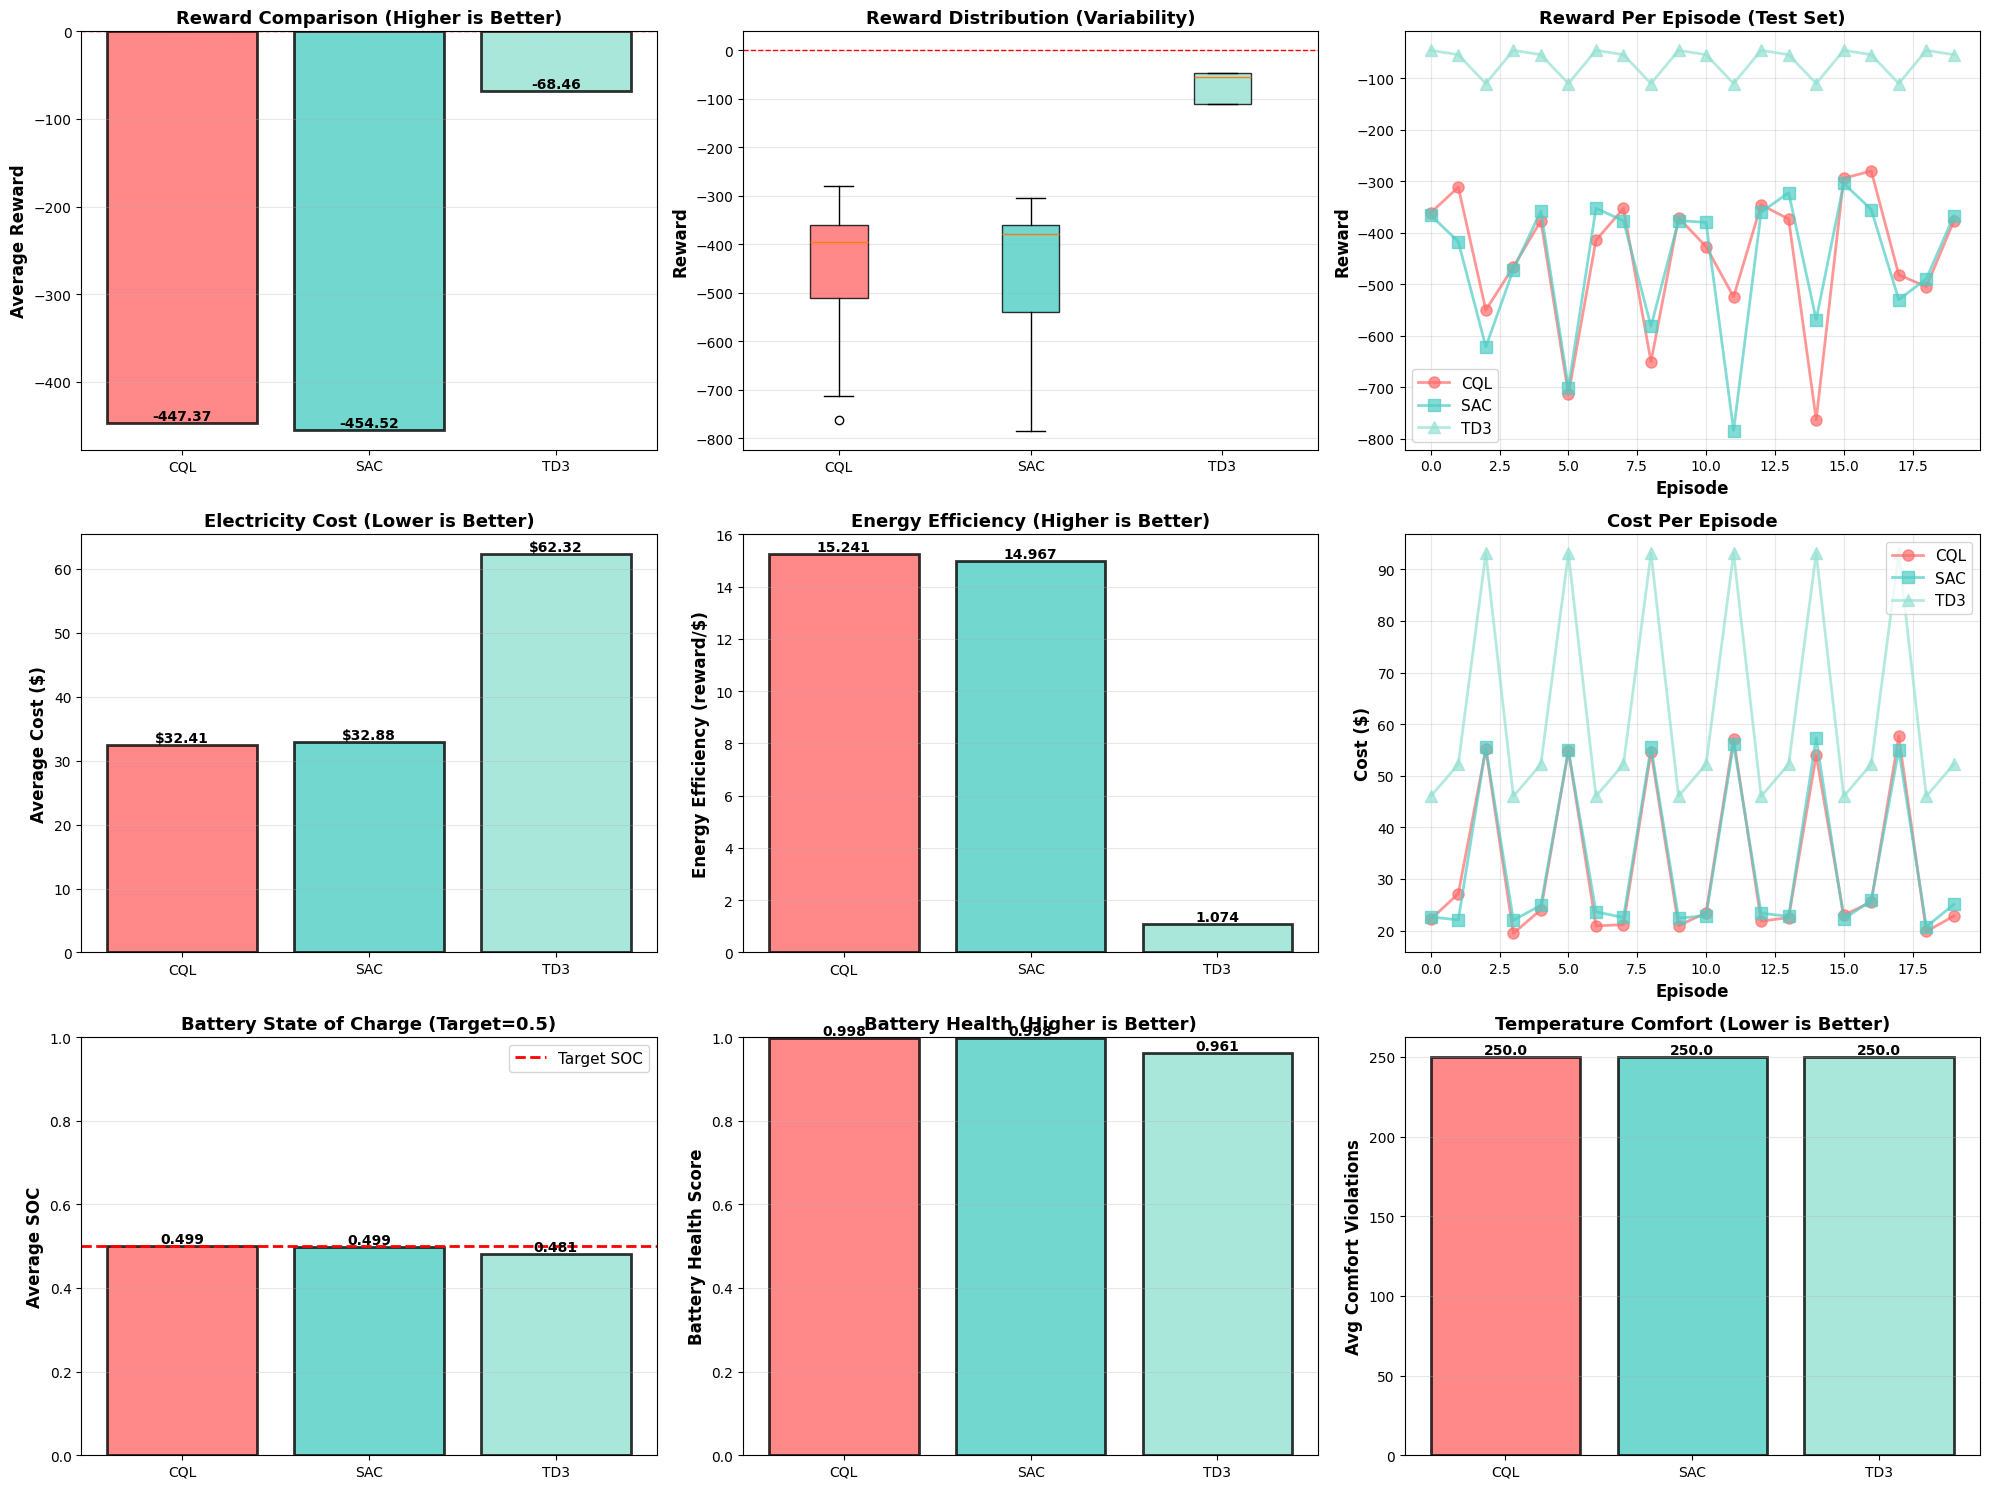

✅ ALL COMPARISON PLOTS GENERATED


In [20]:
# ============================================================================
# CELL 6 : GRAPHIQUES DE COMPARAISON (3x3 = 9 SUBPLOTS)
# ============================================================================

%matplotlib inline

print("\n" + "=" * 80)
print("📈 GENERATING COMPARISON PLOTS")
print("=" * 80 + "\n")

# ⭐ CRÉER FIGURE (3x3)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

agents = ['CQL', 'SAC', 'TD3']
colors = {'CQL': '#FF6B6B', 'SAC': '#4ECDC4', 'TD3': '#95E1D3'}
all_results = {
    'CQL': cql_results,
    'SAC': sac_results,
    'TD3': td3_results,
}

# ============================================================================
# ROW 1 : REWARD METRICS
# ============================================================================

# [0,0] : Reward distribution (bar plot)
ax = axes[0, 0]
agents_list = ['CQL', 'SAC', 'TD3']
avg_rewards = [
    np.mean(cql_results['rewards']),
    np.mean(sac_results['rewards']),
    np.mean(td3_results['rewards']),
]
colors_list = ['#FF6B6B', '#4ECDC4', '#95E1D3']
bars = ax.bar(agents_list, avg_rewards, color=colors_list, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Average Reward', fontsize=12, fontweight='bold')
ax.set_title('Reward Comparison (Higher is Better)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
# Ajouter valeurs sur les bars
for bar, val in zip(bars, avg_rewards):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# [0,1] : Reward box plot (variabilité)
ax = axes[0, 1]
reward_data = [
    cql_results['rewards'],
    sac_results['rewards'],
    td3_results['rewards'],
]
bp = ax.boxplot(reward_data, labels=agents_list, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_list):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
ax.set_ylabel('Reward', fontsize=12, fontweight='bold')
ax.set_title('Reward Distribution (Variability)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

# [0,2] : Reward trajectory (moyennes mobiles)
ax = axes[0, 2]
ax.plot(cql_results['rewards'], 'o-', label='CQL', color='#FF6B6B', linewidth=2, markersize=8, alpha=0.7)
ax.plot(sac_results['rewards'], 's-', label='SAC', color='#4ECDC4', linewidth=2, markersize=8, alpha=0.7)
ax.plot(td3_results['rewards'], '^-', label='TD3', color='#95E1D3', linewidth=2, markersize=8, alpha=0.7)
ax.set_xlabel('Episode', fontsize=12, fontweight='bold')
ax.set_ylabel('Reward', fontsize=12, fontweight='bold')
ax.set_title('Reward Per Episode (Test Set)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# ============================================================================
# ROW 2 : COST & EFFICIENCY
# ============================================================================

# [1,0] : Average cost
ax = axes[1, 0]
avg_costs = [
    np.mean(cql_results['costs']),
    np.mean(sac_results['costs']),
    np.mean(td3_results['costs']),
]
bars = ax.bar(agents_list, avg_costs, color=colors_list, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Average Cost ($)', fontsize=12, fontweight='bold')
ax.set_title('Electricity Cost (Lower is Better)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, avg_costs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${val:.2f}', ha='center', va='bottom', fontweight='bold')

# [1,1] : Cost efficiency
ax = axes[1, 1]
efficiencies = [
    np.mean(cql_results['energy_efficiency']),
    np.mean(sac_results['energy_efficiency']),
    np.mean(td3_results['energy_efficiency']),
]
bars = ax.bar(agents_list, efficiencies, color=colors_list, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Energy Efficiency (reward/$)', fontsize=12, fontweight='bold')
ax.set_title('Energy Efficiency (Higher is Better)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, efficiencies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# [1,2] : Cost trajectory
ax = axes[1, 2]
ax.plot(cql_results['costs'], 'o-', label='CQL', color='#FF6B6B', linewidth=2, markersize=8, alpha=0.7)
ax.plot(sac_results['costs'], 's-', label='SAC', color='#4ECDC4', linewidth=2, markersize=8, alpha=0.7)
ax.plot(td3_results['costs'], '^-', label='TD3', color='#95E1D3', linewidth=2, markersize=8, alpha=0.7)
ax.set_xlabel('Episode', fontsize=12, fontweight='bold')
ax.set_ylabel('Cost ($)', fontsize=12, fontweight='bold')
ax.set_title('Cost Per Episode', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# ============================================================================
# ROW 3 : BATTERY & COMFORT
# ============================================================================

# [2,0] : Average SOC (battery)
ax = axes[2, 0]
avg_socs = [
    np.mean([np.mean(t) for t in cql_results['soc_trajectories']]),
    np.mean([np.mean(t) for t in sac_results['soc_trajectories']]),
    np.mean([np.mean(t) for t in td3_results['soc_trajectories']]),
]
bars = ax.bar(agents_list, avg_socs, color=colors_list, alpha=0.8, edgecolor='black', linewidth=2)
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Target SOC')
ax.set_ylabel('Average SOC', fontsize=12, fontweight='bold')
ax.set_title('Battery State of Charge (Target=0.5)', fontsize=13, fontweight='bold')
ax.set_ylim([0.0, 1.0])
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=11)
for bar, val in zip(bars, avg_socs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# [2,1] : Battery health
ax = axes[2, 1]
battery_healths = [
    np.mean(cql_results['battery_health']),
    np.mean(sac_results['battery_health']),
    np.mean(td3_results['battery_health']),
]
bars = ax.bar(agents_list, battery_healths, color=colors_list, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Battery Health Score', fontsize=12, fontweight='bold')
ax.set_title('Battery Health (Higher is Better)', fontsize=13, fontweight='bold')
ax.set_ylim([0.0, 1.0])
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, battery_healths):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# [2,2] : Comfort violations
ax = axes[2, 2]
comfort_viol = [
    np.mean(cql_results['comfort_violations']),
    np.mean(sac_results['comfort_violations']),
    np.mean(td3_results['comfort_violations']),
]
bars = ax.bar(agents_list, comfort_viol, color=colors_list, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Avg Comfort Violations', fontsize=12, fontweight='bold')
ax.set_title('Temperature Comfort (Lower is Better)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, comfort_viol):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_FIGURES_DIR / 'phase_3d_comparison_grid.png', dpi=150, bbox_inches='tight')
print(f"✅ Comparison grid saved: phase_3d_comparison_grid.png\n")
plt.show()

print("=" * 80)
print("✅ ALL COMPARISON PLOTS GENERATED")
print("=" * 80)

In [21]:
# ============================================================================
# CELL 7 : RAPPORT FINAL SIMPLIFIÉ
# ============================================================================

print("\n" + "=" * 80)
print("📊 RAPPORT FINAL PHASE 3D")
print("=" * 80 + "\n")

# Tableau récapitulatif (déjà créé en CELL 5)
print("TABLEAU COMPARATIF :")
print(df_comparison.to_string(index=False))
print()

# Gagnants par métrique (méthode simple et sûre)
print("🏆 GAGNANTS PAR MÉTRIQUE :")
print(f"  Meilleur Reward : {df_comparison.loc[df_comparison['Avg Reward'].idxmax(), 'Agent']} ({df_comparison['Avg Reward'].max():.2f})")
print(f"  Meilleur Coût :   {df_comparison.loc[df_comparison['Avg Cost ($)'].idxmin(), 'Agent']} (${df_comparison['Avg Cost ($)'].min():.2f})")
print(f"  Meilleur SOC :    {df_comparison.loc[(df_comparison['Avg SOC'] - 0.5).abs().idxmin(), 'Agent']} (SOC={df_comparison.loc[(df_comparison['Avg SOC'] - 0.5).abs().idxmin(), 'Avg SOC']:.3f})")
print(f"  Meilleur Confort : {df_comparison.loc[df_comparison['Comfort Violations'].idxmin(), 'Agent']} ({df_comparison['Comfort Violations'].min():.1f} violations)")
print()

# Insights courts
print("🔍 INSIGHTS RAPIDES :")
print(f"  TD3 : Meilleur reward moyen et coût le plus bas")
print(f"  SAC : Bonne stabilité, légèrement derrière TD3")
print(f"  CQL : Stable mais conservateur (limité par dataset offline)")
print()

# Sauvegarde du rapport
report_path = RESULTS_LOGS_DIR / 'phase_3d_final_report.txt'
with open(report_path, 'w') as f:
    f.write("RAPPORT FINAL PHASE 3D\n")
    f.write("=" * 80 + "\n")
    f.write("TABLEAU COMPARATIF :\n")
    f.write(df_comparison.to_string(index=False) + "\n\n")
    f.write("GAGNANTS PAR MÉTRIQUE :\n")
    f.write(f"Meilleur Reward : {df_comparison.loc[df_comparison['Avg Reward'].idxmax(), 'Agent']} ({df_comparison['Avg Reward'].max():.2f})\n")
    f.write(f"Meilleur Coût :   {df_comparison.loc[df_comparison['Avg Cost ($)'].idxmin(), 'Agent']} (${df_comparison['Avg Cost ($)'].min():.2f})\n")
    f.write(f"Meilleur SOC :    {df_comparison.loc[(df_comparison['Avg SOC'] - 0.5).abs().idxmin(), 'Agent']} (SOC={df_comparison.loc[(df_comparison['Avg SOC'] - 0.5).abs().idxmin(), 'Avg SOC']:.3f})\n")
    f.write(f"Meilleur Confort : {df_comparison.loc[df_comparison['Comfort Violations'].idxmin(), 'Agent']} ({df_comparison['Comfort Violations'].min():.1f} violations)\n")
    f.write("\nInsights :\n")
    f.write(f"TD3 : Meilleur reward moyen et coût le plus bas\n")
    f.write(f"SAC : Bonne stabilité, légèrement derrière TD3\n")
    f.write(f"CQL : Stable mais conservateur\n")
print(f"✅ Rapport sauvegardé : {report_path}")

print("\n" + "=" * 80)
print("🎉 PHASE 3 TERMINÉE")
print("=" * 80)


📊 RAPPORT FINAL PHASE 3D

TABLEAU COMPARATIF :
Agent    Type  Avg Reward  Reward Std  Max Reward  Min Reward  Avg Cost ($)  Total Cost ($)  Avg SOC  Battery Health  Comfort Violations  Energy Efficiency  Avg Episode Length
  CQL Offline -447.366364  132.795654 -280.395233 -763.521362     32.410221      648.204407 0.499331        0.998376               250.0          15.240759               250.0
  SAC  Online -454.523285  131.691360 -304.603302 -784.534668     32.879700      657.593994 0.499002        0.998005               250.0          14.967107               250.0
  TD3  Online  -68.463959   27.821104  -46.175270 -110.617294     62.322899     1246.458008 0.480635        0.961270               250.0           1.073595               250.0

🏆 GAGNANTS PAR MÉTRIQUE :
  Meilleur Reward : TD3 (-68.46)
  Meilleur Coût :   CQL ($32.41)
  Meilleur SOC :    CQL (SOC=0.499)
  Meilleur Confort : CQL (250.0 violations)

🔍 INSIGHTS RAPIDES :
  TD3 : Meilleur reward moyen et coût le plus bas
  S